# Differential Analysis Result Tables 

- [ ] short report about raw data and experiment design 
- [ ] describe analysis workflow and applied tools 
- [ ] describe results (plots, tables)
- [ ] final interpretation 

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib import style 
from statannotations.Annotator import Annotator
# style.use('seaborn-colorblind')
sns.set(style='white')

#adapted from http://nbviewer.ipython.org/github/cs109/content/blob/master/lec_03_statistical_graphs.ipynb    
# https://sourcegraph.com/github.com/mhorlbeck/ScreenProcessing@4d8298df6ab831fd1bd160235488f3450f57363e/-/blob/screen_analysis.py?L570:5
def cleanAxes(axis, top=False, right=False, bottom=True, left=True):
    axis.spines['top'].set_visible(top)
    axis.spines['right'].set_visible(right)
    axis.spines['left'].set_visible(left)
    axis.spines['bottom'].set_visible(bottom)

    #turn off all ticks
    axis.yaxis.set_ticks_position('none')
    axis.xaxis.set_ticks_position('none')

    #now re-enable visibles
    if top:
        axis.xaxis.tick_top()
    if bottom:
        axis.xaxis.tick_bottom()
    if left:
        axis.yaxis.tick_left()
    if right:
        axis.yaxis.tick_right()


In [11]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

## CRISPRi-screen
Aim: analyzing differential phenotype of CRISPRi-screen data

Tool: [ScreenProcessing](https://github.com/mhorlbeck/ScreenProcessing)

#### Result:
`CRISPRi-screen/hl60_exp1/DAC_processing_output_genetable_collapsed.txt`
<!--`CRISPRi-screen/hl60_exp2/DAC_processing_output_genetable_collapsed.txt`-->

<!-- > __Note__: all 5 gRNAs considered here.  -->

- https://github.com/trevismd/statannotations

#### `DESeq2` normalization 
- https://physiology.med.cornell.edu/faculty/skrabanek/lab/angsd/lecture_notes/08_practical.pdf

In [2]:
library(DESeq2)
library(dplyr)

In [3]:
data = read.table(
    'CRISPRi-screen/hl60_exp1/DAC_mergedcountstable.txt',
    sep='\t',header=TRUE,row.names=1)[-c(1,2),]

data <- mutate_all(data, function(x) as.numeric(as.character(x)))

meta = data.frame(
    sampletype=c(rep('T0',2),rep('treated',2),rep('untreated',2)),
    row.names=colnames(data)
)

In [4]:
dds <- DESeqDataSetFromMatrix(countData = data, colData = meta, design = ~ sampletype)
dds <- estimateSizeFactors(dds)
normalized_counts <- counts(dds, normalized=TRUE)
# DESeq.rlog <- rlog(dds, blind = TRUE)
# rlog.norm.counts <- assay(DESeq.rlog)

write.table(
    normalized_counts, 
    # rlog.norm.counts,
    file="CRISPRi-screen/hl60_exp1/DAC_mergedcountstable_normalized_counts.txt", sep="\t", quote=F
)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


#### Barplot

In [142]:
Ci_counts = pd.read_csv('CRISPRi-screen/hl60_exp1/DAC_mergedcountstable_normalized_counts.txt',sep='\t')
Ci_counts.describe().iloc[:3,]

,T0,T0.1,treated,treated.1,untreated,untreated.1
count,104535.00000,104535.00000,104535.000000,104535.000000,104535.000000,104535.000000
mean,545.70697,545.70697,727.478423,727.544124,590.554094,588.936462
std,345.09397,345.09397,2496.508008,2549.954165,478.568782,476.587327


In [143]:
Ci_counts.index = Ci_counts.index.str.split('_').str[0]
Ci_counts.index.name = None
Ci_counts = Ci_counts[Ci_counts.sum(axis=1) > 5]
Ci_counts = Ci_counts[Ci_counts.index != 'non-targeting']
# Ci_counts.describe().iloc[:3,]

In [144]:
def plot_Ci_counts(counts,gene,ax=None,plot='boxplot',ylim=None,T0=False):
    
    # df = counts[counts.gene == gene].drop('gene',axis=1).T
    df = counts[counts.index == gene].T
    # select top 3 sgRNAs
    df = pd.DataFrame(
        [list(df.iloc[row,:].nlargest(3)) for row,_ in enumerate(df.index)],
        index=[row_id for _,row_id in enumerate(df.index)],
        columns=[gene,gene,gene]
    )
    df['treatment'] = ["T0","T0","Decitabine","Decitabine","DMSO","DMSO"]
    # df_column_uniquify
    df_columns = df.columns
    new_columns = []
    for counter,item in enumerate(df_columns):
        if gene in item:
            newitem = "{}_gRNA{}".format(item, counter + 1)
        else:
            newitem = item
        new_columns.append(newitem)
    df.columns = new_columns
    
    dd=pd.melt(
        df,
        id_vars='treatment',value_vars=[col for col in df.columns if gene in col],var_name='columns'
    )
    data_title = "gRNA count" # Normalized
    dd = dd.rename({'value':data_title},axis=1)
    dd[data_title] = dd[data_title].astype(int)
    my_pal = {"Decitabine": "c", "DMSO": "lightgray", 'T0':'azure'}
    
    if not T0:
        dd = dd[dd.treatment != 'T0'].sort_values(by='treatment', axis=0, ascending=True)
    if ax:
        cleanAxes(ax)
        if plot == 'pointplot':
            p = sns.pointplot(x='treatment',y=data_title,data=dd,hue='treatment',palette=my_pal,ax=ax)

        if plot == 'boxplot':
            p = sns.boxplot(x='treatment',y=data_title,data=dd,hue='treatment',palette=my_pal,ax=ax)
        
        pairs=[("Decitabine","DMSO")]

        annotator = Annotator(ax, pairs, x='treatment',y=data_title,data=dd)
        annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
        annotator.apply_and_annotate()
        ax.set_title(gene,y=1.15,fontsize=14)
        ax.set_xlabel(None)
        ax.set_ylim(top=ylim)
        ax.set_yscale('log')

        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
            
        # return p
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.tick_params(axis='both', which='minor', labelsize=8)

    else: 
        return dd

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DMSO vs. Decitabine: Mann-Whitney-Wilcoxon test two-sided, P_val:3.064e-02 U_stat=3.200e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DMSO vs. Decitabine: Mann-Whitney-Wilcoxon test two-sided, P_val:3.064e-02 U_stat=3.200e+01


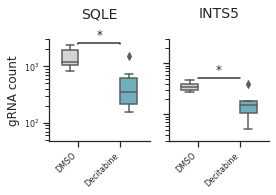

In [148]:
f, axes = plt.subplots(1, 2,figsize=(4,3))
leg = plt.legend()

plot_Ci_counts(Ci_counts,gene = 'SQLE',ax=axes[0],ylim=3000)
plot_Ci_counts(Ci_counts,gene = 'INTS5',ax=axes[1],ylim=3000)

for ax in axes:
    ax.get_legend().remove()
    
axes[1].set_ylabel(None)
axes[1].tick_params(axis='y',label1On=False)
# axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

f.tight_layout()
f.savefig('Target-genes/Ci_counts.pdf')

In [55]:
# f, axes = plt.subplots(1, 2,figsize=(6,3))

# plot_Ci_counts(Ci_counts,gene = 'BCL2',ax=axes[0])
# plot_Ci_counts(Ci_counts,gene = 'FDFT1',ax=axes[1])

# for ax in axes:
#     leg = plt.legend()
#     ax.get_legend().remove()
# # axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.tight_layout()

## RNA-seq
Aim-1: analyzing differential experssion of RNA-seq data

Tool: [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html), [iPAGE](https://github.com/goodarzilab/PAGE)

#### Result: 
`RNA-seq/hl60-exp/hl60_exp_deseq2_norm.txt` - normalized counts 

`RNA-seq/hl60-exp/hl60_delta_exp_table.txt`
- `gene_id`
- `gene_name`
- `baseMean`
- `log2FC_6h`
- `pval_6h`
- `log2FC_72h`
- `pval_72h`
- `log2FC_120h`
- `pval_120h`

Aim-2: cell line consistency analysis 


In [382]:
# exp = pd.read_csv('RNA-seq/exp/delta_exp_table.txt',sep='\t')

### Expression

In [6]:
exp_counts  = pd.read_csv('RNA-seq/exp/deseq2_norm.txt',sep='\t')

In [149]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return ""

def plot_time_rna_seq(counts,gene,ax,data,plot='boxplot',ymin=None,ylim=None):
    
    df = counts[counts['name'] == gene].set_index('name').T
    df['treatment'] = df.index.str.split('_').str[-2]
    df['line'] = df.index.str.split('_').str[0]
    df['time'] = 72
    df.loc[df.line == 'hl60','time'] = df[df.line == 'hl60'].index.str.split('_').str[1].str[:-1].astype(int)
    dd=pd.melt(
        df[df.line == 'hl60'],
        id_vars=['treatment','time'],value_vars=[gene],var_name='columns'
    ).sort_values(by='time', axis=0, ascending=True)
    dd['treatment'] = dd['treatment'].str.replace('t', 'Decitabine')
    dd['treatment'] = dd['treatment'].str.replace('u', 'DMSO')
    dd = dd.sort_values(by='treatment', axis=0, ascending=True).rename({'value':f'{data}'},axis=1)

    my_pal = {"Decitabine": "c", "DMSO": "lightgray"}
    
    cleanAxes(ax)
    if plot == 'pointplot':
        p = sns.pointplot(x='time',y=f'{data}',data=dd,hue='treatment',palette=my_pal,ax=ax)
        
        # perform two-way ANOVA
        model = ols(f'{data} ~ treatment + time + treatment:time', data=dd).fit()
        pvalue = round(sm.stats.anova_lm(model, typ=2).iloc[0,3],3)
        star = convert_pvalue_to_asterisks(pvalue)
        # add pvalue as text
        ax.text(0.8, 1,
                # ,
                f'{star} P={pvalue}', 
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=8,color='darkblue',
                weight="bold",
                transform = ax.transAxes
               )
        ax.set_title(gene,y=1.15,fontsize=14)
    
    # ax.set_ylim([ymin,ylim])
    # ax.set_yscale('log')
    if plot == 'boxplot':
        p = sns.boxplot(x='time',y=f'{data}',data=dd,hue='treatment',palette=my_pal,ax=ax)
    
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)

    return p

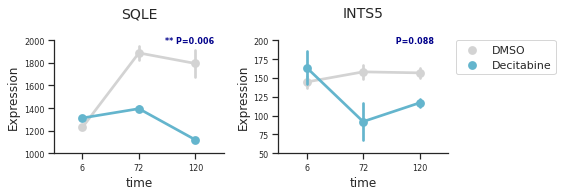

In [150]:
f, axes = plt.subplots(1, 2,figsize=(8,3))

plot_time_rna_seq(exp_counts,gene = 'SQLE',ax=axes[0],data='Expression',plot='pointplot')
axes[0].get_legend().remove()
axes[0].set_ylim(bottom=1000,top=2000)
# axes[0].set_yscale('log')

plot_time_rna_seq(exp_counts,gene = 'INTS5',ax=axes[1],data='Expression',plot='pointplot')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[1].set_ylim(bottom=50,top=200)

plt.tight_layout()
plt.savefig('Target-genes/Exp.pdf')

In [151]:
# plot_time_rna_seq(exp_counts,gene = 'SQLE',ax=axes[0,0],data='Expression',ylim=ylim)
# leg = f.legend()
# axes[0,0].get_legend().remove()
# plot_time_rna_seq(exp_counts,gene = 'INTS5',ax=axes[0,1],data='Expression',ylim=ylim)
# axes[0,1].get_legend().remove()


## Stability

In [152]:
stbl_counts_norm = pd.read_csv('RNA-seq/stbl/normalized_stbl_count_table.txt',sep='\t')
stbl_counts = pd.read_csv('RNA-seq/stbl/REMBRANDTS.txt',sep='\t').set_index('GeneID').loc[stbl_counts_norm.index,]
stbl_counts['name'] = stbl_counts_norm['name']
# stbl_counts.set_index('name',inplace=True)

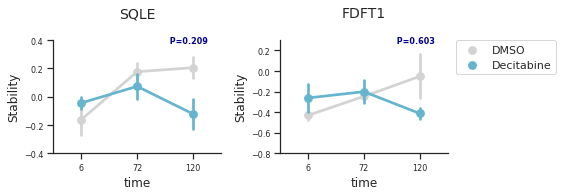

In [153]:
f, axes = plt.subplots(1, 2,figsize=(8,3))

plot_time_rna_seq(stbl_counts,gene = 'SQLE',ax=axes[0],data='Stability',plot='pointplot',ylim=ylim)
axes[0].get_legend().remove()
axes[0].set_ylim(bottom=-0.4,top=0.4)

plot_time_rna_seq(stbl_counts,gene = 'FDFT1',ax=axes[1],data='Stability',plot='pointplot',ylim=ylim)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[1].set_ylim(bottom=-0.8,top=0.3)

plt.tight_layout()
plt.savefig('Target-genes/Stbl.pdf')

In [133]:
# f, axes = plt.subplots(2, 2,figsize=(10,6))

# plot_time_rna_seq(stbl_counts,gene = 'SQLE',ax=axes[0,0],data='Stability',plot='pointplot')
# axes[0,0].legend('')
# plot_time_rna_seq(stbl_counts,gene = 'FDFT1',ax=axes[0,1],data='Stability',plot='pointplot')
# axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plot_time_rna_seq(stbl_counts,gene = 'CES1',ax=axes[1,0],data='Stability',plot='pointplot')
# axes[1,0].legend('')
# plot_time_rna_seq(stbl_counts,gene = 'TGFBR1',ax=axes[1,1],data='Stability',plot='pointplot')
# axes[1,1].legend('')

# plt.tight_layout()

> #### FDFT1
> [__Azacitidine in combination with chemotherapy in pediatric AML patients– a phase I study__](https://aml-hub.com/medical-information/azacitidine-in-combination-with-chemotherapy-in-pediatric-aml-patients-a-phase-i-study)
> - _FDFT1 was significantly different between responders and non-responders, P = 0.002_

## meRIP-seq
Experiment design: Two replicates of samples for both treated with Decitabine drug and non-treated (
`T1.input.bam`
`T1.m6A.bam`
`T2.input.bam`
`T2.m6A.bam`
`U1.input.bam`
`U1.m6A.bam`
`U2.input.bam`
`U2.m6A.bam`
) used for meRIP-seq experiment. 

Aim: analyzing differential methylation of MeRIP-seq data

Tool: [RADAR](https://github.com/scottzijiezhang/RADAR)

#### Result: 
`meRIP-seq/hl60_delta_mtyl_table.txt`. 
_Columns_: 
- `chr`
- `start`
- `end`
- `name`
- `score`
- `strand`
- `thickStart`
- `thickEnd`
- `itemRgb`
- `blockCount`
- `blockSizes`
- `blockStarts`
- `logFC`
- `p_value`
- `ensembl`

## Ribo-seq

Aim: analyzing differential translation of Ribo-seq data

Tool: [Ribolog](https://github.com/goodarzilab/Ribolog)


#### Result:
`Ribo-seq/hl60_delta_te_table.txt`

- `transcript`
- `gene_id`
- `gene_name`
- `Estimate_treatmentDRUG`
- `Pr...z.._treatmentDRUG`
- `fdr_Pr...z.._treatmentDRUG`
- `qvalue_Pr...z.._treatmentDRUG`


# Combined Analysis

- [ ] describe analysis purpose 
- [ ] describe results (plots, tables)
- [ ] final interpretation 

## hyper-geometric-test

## mtyl-enrichment

## intersectional-genes
